In [18]:
import os, re, ast
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

CSV_IN  = "all_subreddits_merged.csv"
CSV_OUT = "all_subreddits_merged_clean.csv"   # set to CSV_IN to overwrite
OUT_DIR = "Output"
os.makedirs(OUT_DIR, exist_ok=True)

In [20]:
df = pd.read_csv(CSV_IN)

# Common column names
TOKEN_COLS = ["tokens", "token", "clean_tokens", "tokens_list"]
TEXT_COLS  = ["clean_text", "cleaned_text", "text_clean", "text"]
TITLE_KEYS = {"title"}
BODY_KEYS  = {"selftext", "body", "post", "content"}

token_col = next((c for c in TOKEN_COLS if c in df.columns), None)
text_col  = next((c for c in TEXT_COLS  if c in df.columns), None)
title_col = next((c for c in df.columns if c.lower() in TITLE_KEYS), None)
body_col  = next((c for c in df.columns if c.lower() in BODY_KEYS), None)

print("Detected:", {"token_col": token_col, "text_col": text_col, "title_col": title_col, "body_col": body_col})

Detected: {'token_col': 'tokens', 'text_col': 'clean_text', 'title_col': 'title', 'body_col': None}


In [21]:
# Parse token cell -> list[str]
def coerce_tokens(x):
    if pd.isna(x): return []
    if isinstance(x, list): return [t for t in x if isinstance(t, str)]
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            lst = ast.literal_eval(x)
            return [t for t in lst if isinstance(t, str)]
        except Exception:
            pass
    if isinstance(x, str): return x.split()
    return []

# Junk rules (add more if you see noise)
JUNK_PATTERNS = [
    r"^[’“”\"'`]+$",     # quotes only
    r"^[^a-z0-9]+$",     # non-alnum only
    r"^\d+$",            # numbers
    r"^.$",              # single char
    r"^http.*",          # urls
    r"^www.*",
    r"^html$",
    r"^amp$",
]
junk_regex = re.compile("|".join(JUNK_PATTERNS))

PUNCT_STRIP = "’“”\"'`.,!?;:()[]{}<>|/~\\"

def clean_token(t):
    t = (t or "").strip(PUNCT_STRIP).lower()
    if not t or junk_regex.match(t): return None
    return t

def clean_token_list(tokens):
    out = []
    for t in tokens:
        ct = clean_token(t)
        if ct: out.append(ct)
    return out

In [22]:
if token_col:
    tok_series = df[token_col].apply(coerce_tokens)
elif text_col:
    tok_series = df[text_col].fillna("").astype(str).str.split()
elif title_col or body_col:
    concat = (df[title_col].fillna("") if title_col else "") + " " + (df[body_col].fillna("") if body_col else "")
    tok_series = concat.astype(str).str.split()
else:
    raise ValueError("No suitable text/tokens source found.")

df["tokens_clean"] = tok_series.apply(clean_token_list)

# Drop rows that became empty after cleaning (optional)
df = df[df["tokens_clean"].map(len) > 0].reset_index(drop=True)

print(df[["tokens_clean"]].head(3))
print("Rows:", len(df))

                                        tokens_clean
0  [psychiatrist, decided, switch, concerta, stra...
1  [trouble, uni, spoke, favorite, teacher, anoth...
2  [socially, shy, growing, usually, quiet, situa...
Rows: 95250


In [23]:
df.to_csv(CSV_OUT, index=False)
print("Saved cleaned CSV ->", CSV_OUT)

Saved cleaned CSV -> all_subreddits_merged_clean.csv


In [24]:
TOKENS = [t for row in df["tokens_clean"] for t in row]
print("Total tokens:", len(TOKENS), "| Unique:", len(set(TOKENS)))

Total tokens: 5376982 | Unique: 105905


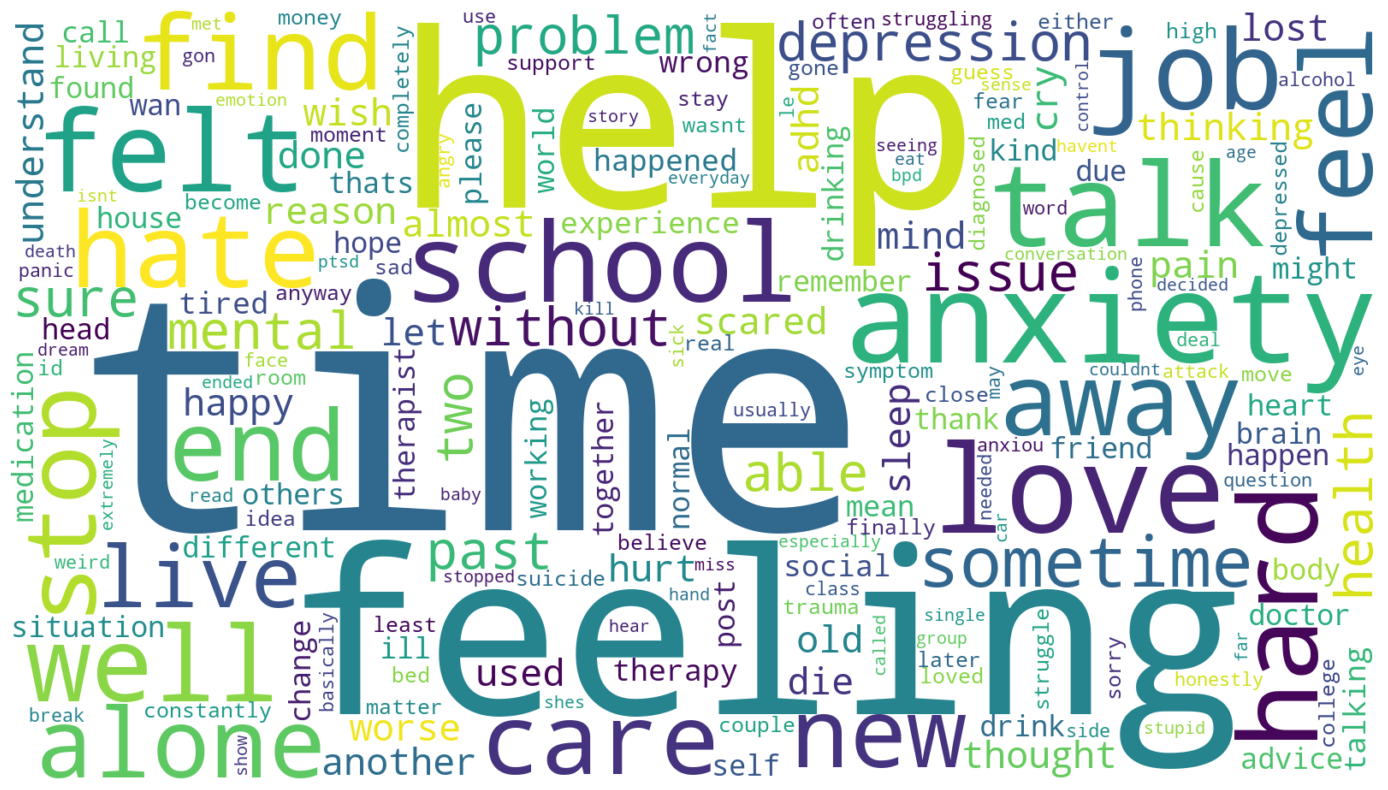

Saved: Output/merged_wordcloud_clean.png


In [25]:
# Add custom stopwords here if you spot domain-specific junk
extra_stop = set()  # e.g., {"amp", "im", "dont"}
stopwords = set(STOPWORDS) | extra_stop

corpus = " ".join(TOKENS)
wc = WordCloud(width=1600, height=900, background_color="white",
               collocations=False, stopwords=stopwords).generate(corpus)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
wc_path = os.path.join(OUT_DIR, "merged_wordcloud_clean.png")
plt.savefig(wc_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", wc_path)

In [26]:
from itertools import islice

def top_ngrams(tokens, n=2, k=30, min_len=2, max_len=30):
    toks = [t for t in tokens if min_len <= len(t) <= max_len]
    grams = zip(*(islice(toks, i, None) for i in range(n)))
    # filter out grams where all words identical: ("die","die","die")
    grams = [g for g in grams if not all(w == g[0] for w in g)]
    return Counter(grams).most_common(k)

def plot_ngrams(top_items, title, outfile):
    labels = [" ".join(g) for g, _ in top_items]
    counts = [c for _, c in top_items]
    plt.figure(figsize=(12, 8))
    plt.barh(labels[::-1], counts[::-1])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", outfile)

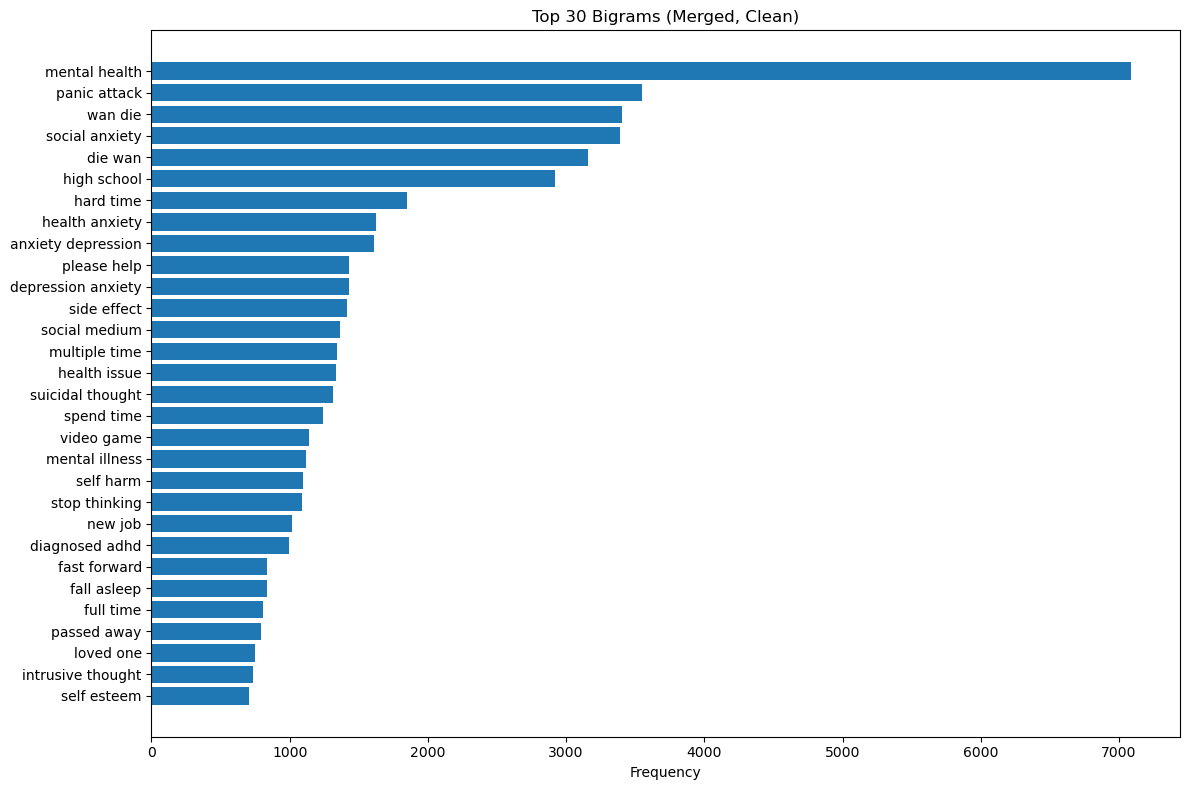

Saved: Output/merged_bigrams_top30_clean.png


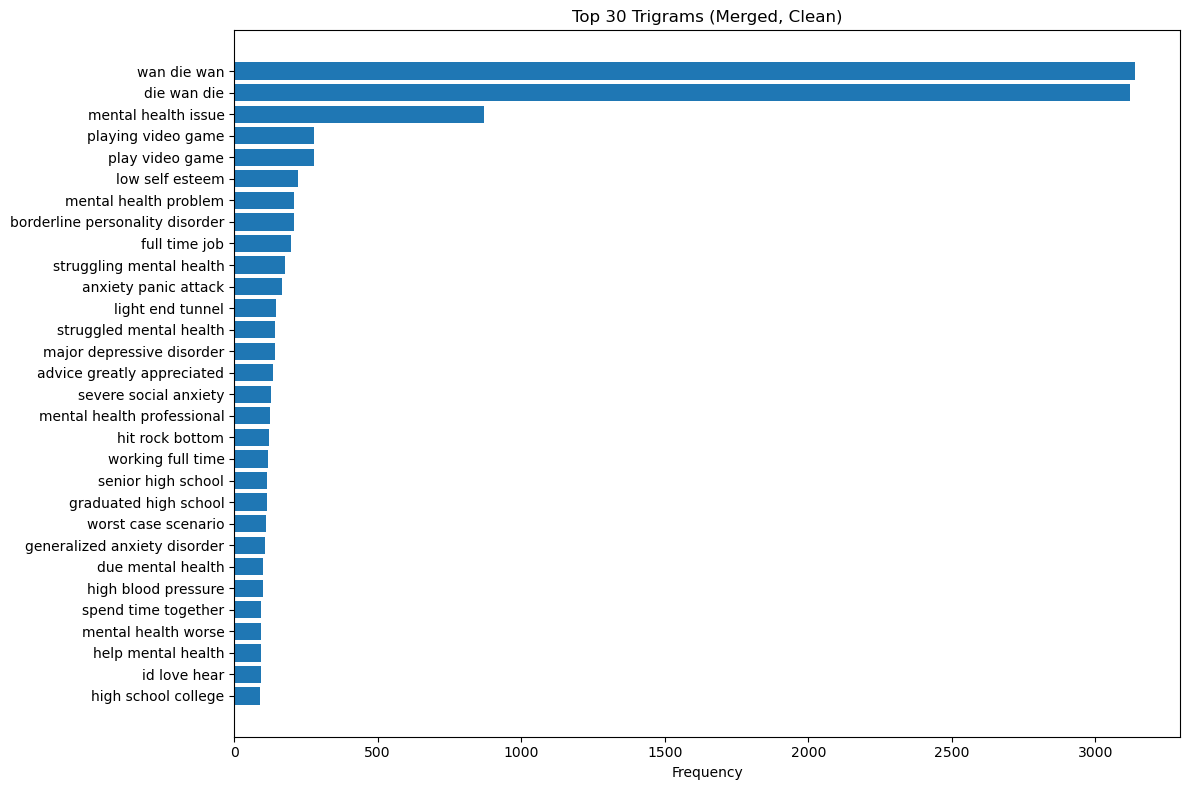

Saved: Output/merged_trigrams_top30_clean.png


In [27]:
top_bi  = top_ngrams(TOKENS, n=2, k=30)
top_tri = top_ngrams(TOKENS, n=3, k=30)

bi_path  = os.path.join(OUT_DIR, "merged_bigrams_top30_clean.png")
tri_path = os.path.join(OUT_DIR, "merged_trigrams_top30_clean.png")

plot_ngrams(top_bi,  "Top 30 Bigrams (Merged, Clean)",  bi_path)
plot_ngrams(top_tri, "Top 30 Trigrams (Merged, Clean)", tri_path)